In [7]:
# import library 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random


In [8]:
# device set up
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Data preprocessing and loading
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
])
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='dataset/train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = datasets.ImageFolder(root='dataset/test', transform=simple_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [10]:
# Load EfficientNet-B0 model and reconfigure the last layer
model_efficientnet_b0 = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT).to(device)
in_features = model_efficientnet_b0.classifier[1].in_features
output_shape = len(train_dataset.classes)  # Determine the number of classes

model_efficientnet_b0.classifier[1] = nn.Linear(in_features, output_shape).to(device)

In [34]:
# Define loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_efficientnet_b0.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [35]:

# Training parameters
num_epochs = 15
test_interval = 1  # How many epochs to predict
best_accuracy = 0.0  # Initialize the best test accuracy
prev_test_accuracy = 0.0  # Previous test accuracy
increase_count = 0  # Increase or decrease counter

# To store accuracy and loss values
train_acc_history = []
test_acc_history = []
loss_history = [] 

# Training loop
for epoch in range(num_epochs):
    model_efficientnet_b0.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_efficientnet_b0(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        progress_bar.set_postfix({'loss': running_loss / len(train_loader.dataset)})

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    train_acc_history.append(train_accuracy)
    loss_history.append(epoch_loss)  # Store the epoch loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    
    # Step the learning rate scheduler
    scheduler.step()

    # Evaluate the model at every test_interval epoch
    if (epoch + 1) % test_interval == 0:
        model_efficientnet_b0.eval()
        correct_test = 0
        total_test = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model_efficientnet_b0(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_accuracy = 100 * correct_test / total_test
        test_acc_history.append(test_accuracy)
        print(f"Test Accuracy after {epoch+1} epochs: {test_accuracy:.2f}%")

        # Check if test accuracy is decreasing or if loss is increasing linearly
        if test_accuracy <= prev_test_accuracy:
            increase_count += 1
        else:
            increase_count = 0

        # If accuracy or loss increases linearly for 5 consecutive checks, stop training
        if increase_count >= 5:
            print(f"Test accuracy decreased linearly. Stopping training.")
            break
            
        prev_test_accuracy = test_accuracy

# Final evaluation
print(f"Final Test Accuracy: {prev_test_accuracy:.2f}%")

Epoch [1/15], Loss: 0.3203, Train Accuracy: 90.14%
Test Accuracy after 1 epochs: 92.60%


Epoch [2/15], Loss: 0.2810, Train Accuracy: 91.13%
Test Accuracy after 2 epochs: 91.40%


Epoch [3/15], Loss: 0.2693, Train Accuracy: 91.57%
Test Accuracy after 3 epochs: 92.20%


Epoch [4/15], Loss: 0.2656, Train Accuracy: 91.72%
Test Accuracy after 4 epochs: 93.60%


Epoch [5/15], Loss: 0.2472, Train Accuracy: 92.01%
Test Accuracy after 5 epochs: 93.90%


Epoch [6/15], Loss: 0.1381, Train Accuracy: 95.40%
Test Accuracy after 6 epochs: 96.20%


Epoch [7/15], Loss: 0.0949, Train Accuracy: 96.86%
Test Accuracy after 7 epochs: 96.10%


Epoch [8/15], Loss: 0.0848, Train Accuracy: 97.37%
Test Accuracy after 8 epochs: 96.20%


Epoch [9/15], Loss: 0.0772, Train Accuracy: 97.66%
Test Accuracy after 9 epochs: 96.50%


Epoch [10/15], Loss: 0.0703, Train Accuracy: 97.52%
Test Accuracy after 10 epochs: 96.40%


Epoch [11/15], Loss: 0.0617, Train Accuracy: 97.94%
Test Accuracy after 11 epochs: 96.70%


Epoch [12/15], Loss: 0.0613, Train Accuracy: 97.99%
Test Accuracy after 12 epochs: 96.60%


Epoch [13/15], Loss: 0.0622, Train Accuracy: 98.00%
Test Accuracy after 13 epochs: 96.60%


Epoch [14/15], Loss: 0.0589, Train Accuracy: 98.10%
Test Accuracy after 14 epochs: 96.80%


Epoch [15/15], Loss: 0.0582, Train Accuracy: 98.11%
Test Accuracy after 15 epochs: 96.70%
Final Test Accuracy: 96.70%


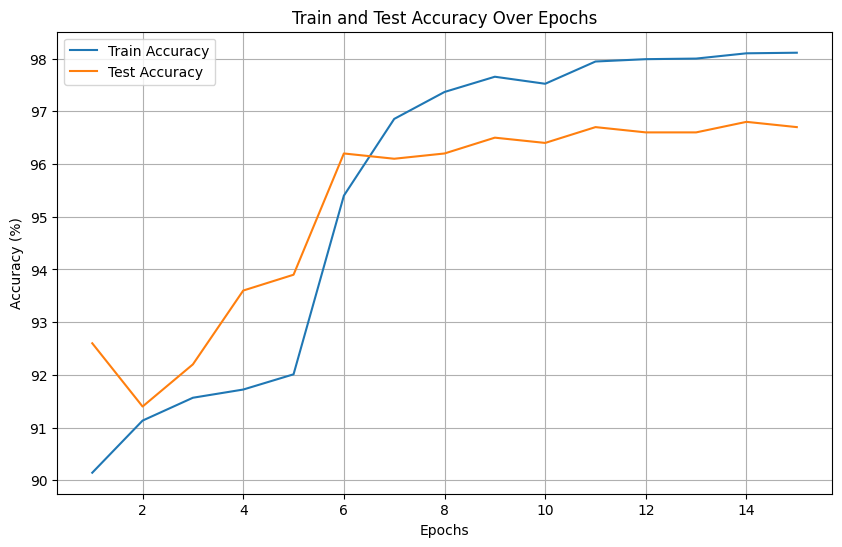

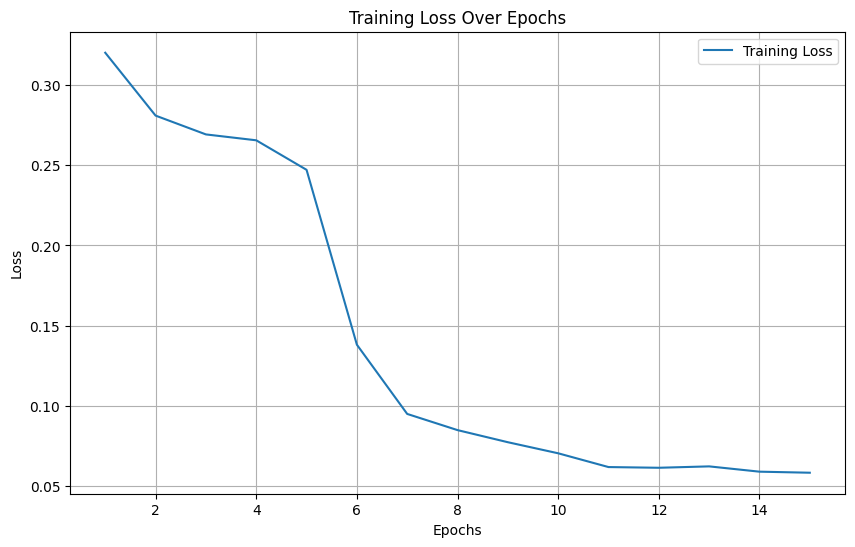

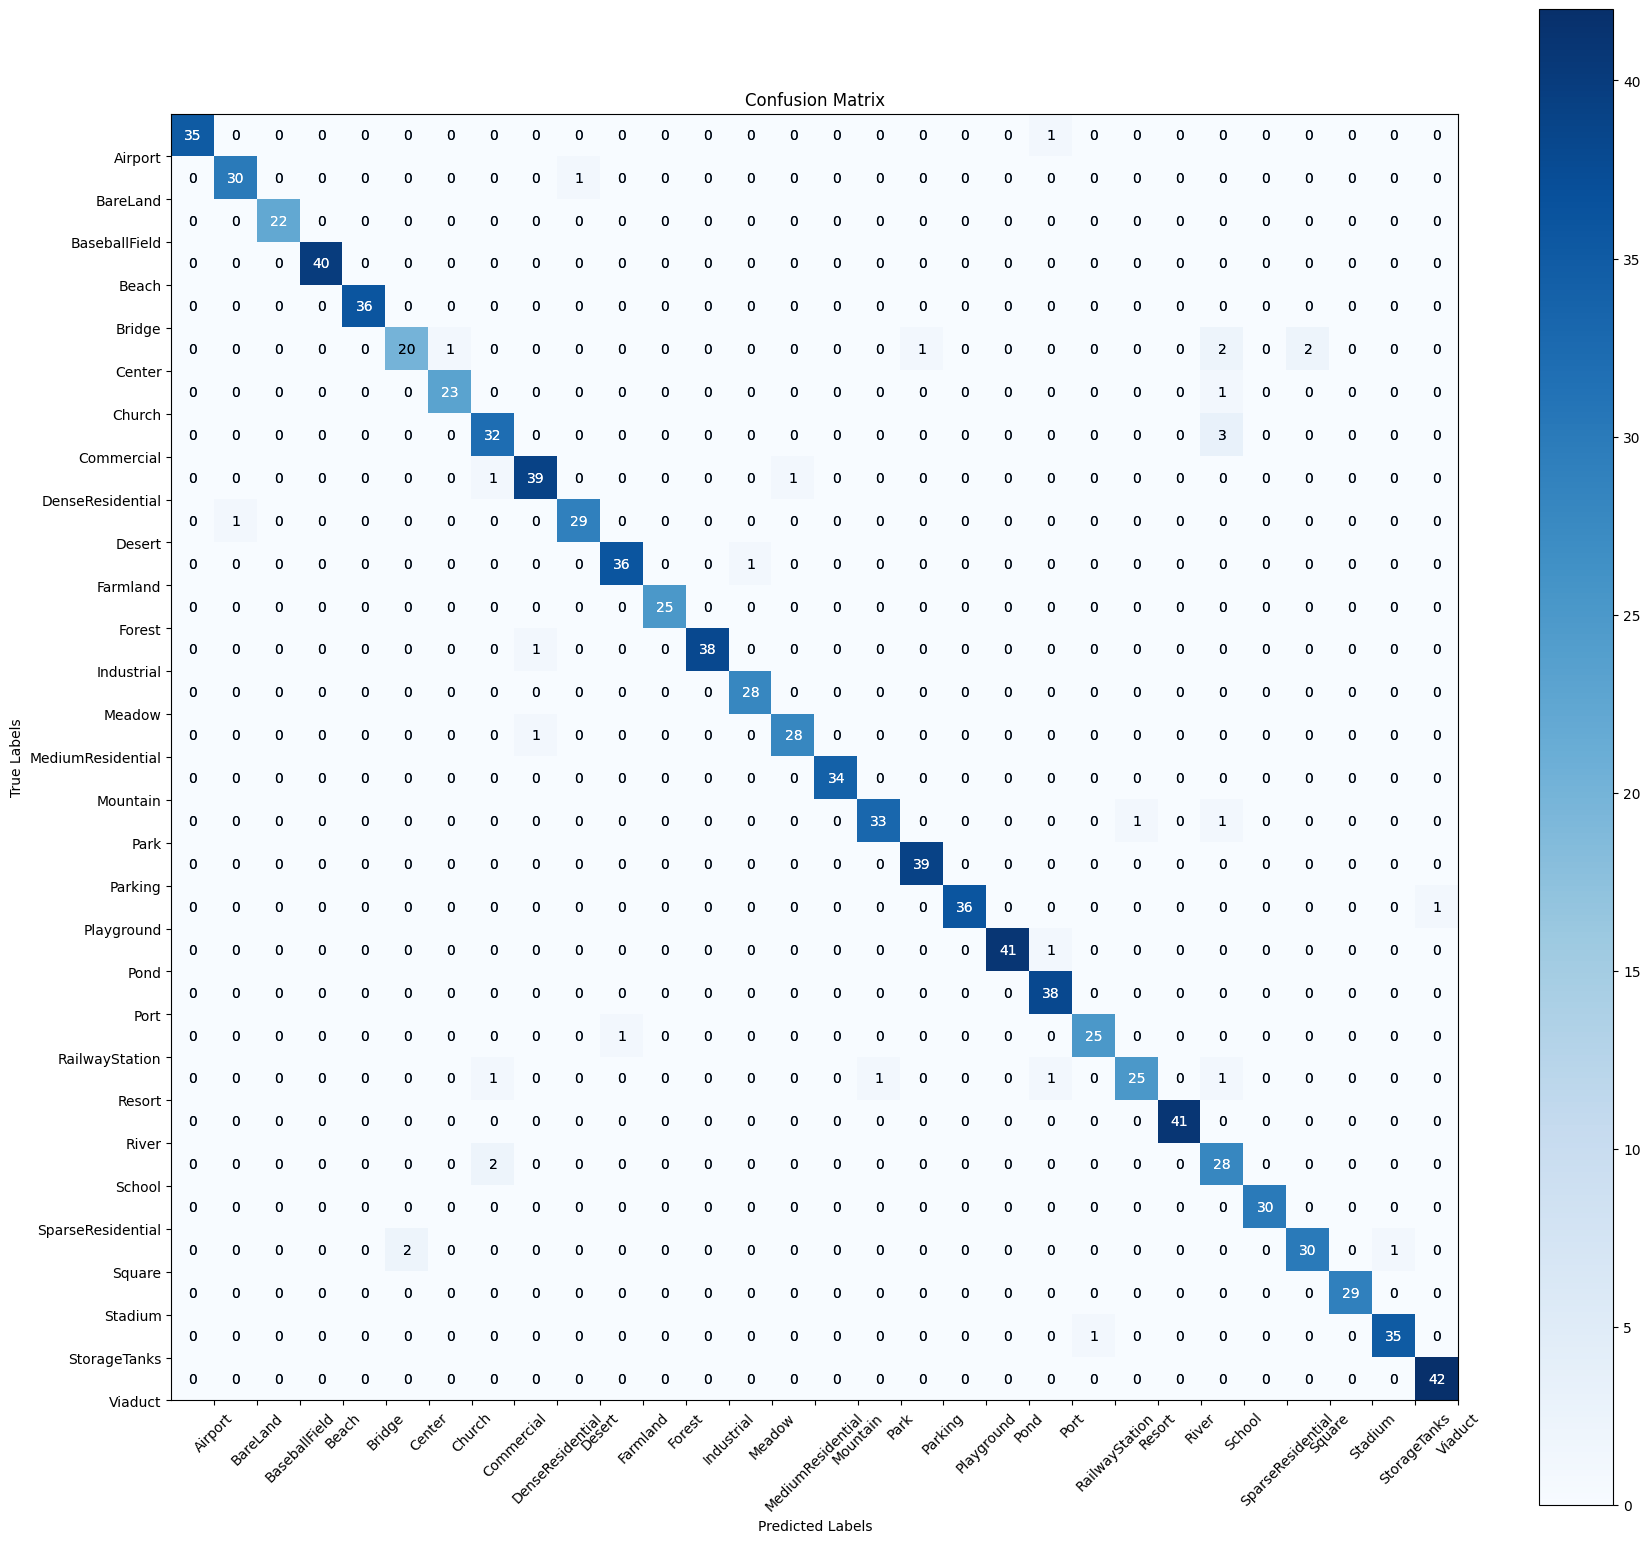

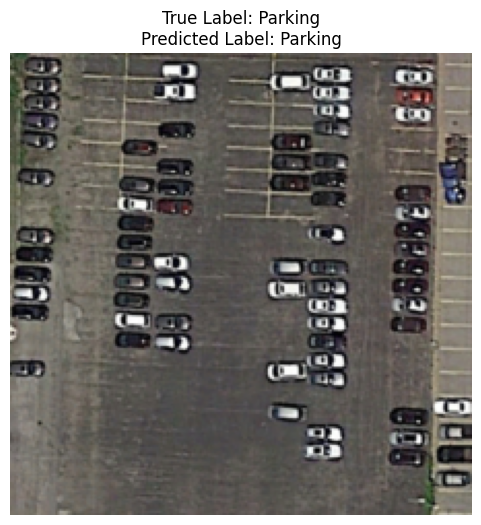

In [36]:
# Plotting accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, len(test_acc_history) + 1), test_acc_history, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Select a random test image and predict
random_idx = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_idx]
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
model_efficientnet_b0.eval()
with torch.no_grad():
    output = model_efficientnet_b0(image)
    _, predicted = torch.max(output, 1)

# Create and plot confusion matrix with sklearn ConfusionMatrixDisplay
cm = confusion_matrix(all_labels, all_preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=train_dataset.classes)
plt.figure(figsize=(18, 16))  # Increased size
cmd.plot(cmap='Blues', values_format='d', ax=plt.gca())  # Use Blues colormap for confusion matrix
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(train_dataset.classes))+0.5, labels=train_dataset.classes, rotation=45)
plt.yticks(ticks=np.arange(len(train_dataset.classes))+0.5, labels=train_dataset.classes, rotation=0)

# Change cell colors based on the intensity of the cell value
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 wrap=True)  # Wrap text if it exceeds cell size

plt.tight_layout()  
plt.show()

# Select a random test image and predict
random_idx = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_idx]
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
model_efficientnet_b0.eval()
with torch.no_grad():
    output = model_efficientnet_b0(image)
    _, predicted = torch.max(output, 1)

# Visualize the image and prediction
image = image.squeeze(0).cpu().numpy().transpose((1, 2, 0))
image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Undo normalization
image = np.clip(image, 0, 1)  # Bring values to [0, 1] range

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f'True Label: {train_dataset.classes[label]}\nPredicted Label: {train_dataset.classes[predicted.item()]}')
plt.axis('off')
plt.show()
